In [2]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score
from sklearn.model_selection import train_test_split

%matplotlib inline

In [453]:
df = pd.read_csv("data/train.csv", index_col=0)
# df['Deck'] = df[~df['Cabin'].isnull()]['Cabin'].str[0]
df['Title'] = df['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())
df['FamSize'] = df['Parch'] + df['SibSp']

decks_df = df['Cabin'].str.extract('(?P<Deck>\w)(?P<CabinNumber>\d+)', expand=True)
deck_dummies = pd.get_dummies(decks_df['Deck'], prefix='Deck')
title_dummies = pd.get_dummies(df['Title'])
gender_dummies = pd.get_dummies(df['Sex'])
class_dummies = pd.get_dummies(df['Pclass'], prefix='Class')
embarked_dummies = pd.get_dummies(df['Embarked'], )
has_age = df['Age'].notnull().astype('int')
has_age.name = 'has_age'

# saving to variables and using .concat() once seems to be much faster
df = pd.concat([df, decks_df, deck_dummies, title_dummies, gender_dummies, class_dummies, has_age], axis=1)
df['Age'].fillna(0, inplace=True)

In [373]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

(array([ 227.,   33.,  164.,  181.,  123.,   74.,   50.,   26.,   11.,    2.]),
 array([  0.,   8.,  16.,  24.,  32.,  40.,  48.,  56.,  64.,  72.,  80.]),
 <a list of 10 Patch objects>)

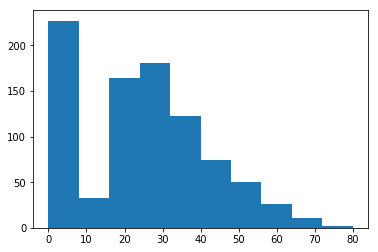

In [425]:
plt.hist(df['Age'])

In [426]:
has_age.sum()

714

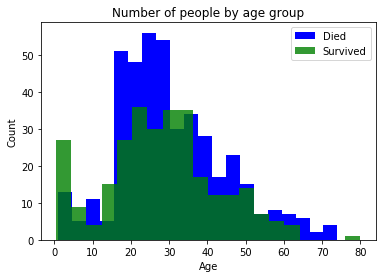

In [437]:
plt.hist(df[(df['Survived'] == 0) & (df['has_age'] == 1)]['Age'], color='b', label='Died', bins=20)
plt.hist(df[(df['Survived'] == 1) & (df['has_age'] == 1)]['Age'], color='g', alpha=0.8, label='Survived', bins=20)
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Number of people by age group')
plt.legend()
plt.show()

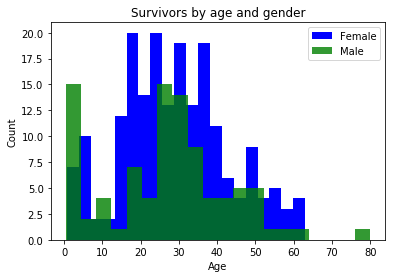

In [448]:
male_survivor_ages = df[(df['Survived'] == 1) & (df['has_age'] == 1) & (df['male'] == 1)]['Age']
female_survivor_ages = df[(df['Survived'] == 1) & (df['has_age'] == 1) & (df['female'] == 1)]['Age']

plt.hist(female_survivor_ages, color='b', label='Female', bins=20)
plt.hist(male_survivor_ages, color='g', label='Male', bins=20, alpha=.8)
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Survivors by age and gender')
plt.legend()
plt.show()

### Logistic Regression (no feature engineering)

In [279]:
X = df[['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']]
y = X.pop('Survived')

In [280]:
df[['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']].describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,23.799293,0.523008,0.381594,32.204208
std,0.486592,0.836071,17.596074,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,6.000000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,24.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [281]:
X.describe()

,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000
mean,2.308642,23.799293,0.523008,0.381594,32.204208
std,0.836071,17.596074,1.102743,0.806057,49.693429
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,6.000000,0.000000,0.000000,7.910400
50%,3.000000,24.000000,0.000000,0.000000,14.454200
75%,3.000000,35.000000,1.000000,0.000000,31.000000
max,3.000000,80.000000,8.000000,6.000000,512.329200


In [282]:
X_train_minimal, X_test_minimal, y_train_minimal, y_test_minimal = train_test_split(X, y)

logreg = LogisticRegressionCV(n_jobs=-1)

logreg.fit(X_train_minimal, y_train_minimal)

y_pred = logreg.predict(X_test_minimal)

cfn_matrix_minimal = confusion_matrix(y_test_minimal, y_pred)
np.set_printoptions(precision=2)

Confusion matrix, without normalization
[[120  16]
 [ 52  35]]


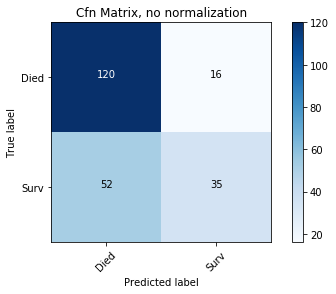

In [283]:
plt.figure()
plot_confusion_matrix(cfn_matrix_minimal, ['Died', 'Surv'], title="Cfn Matrix, no normalization")

Normalized confusion matrix
[[ 0.88  0.12]
 [ 0.6   0.4 ]]


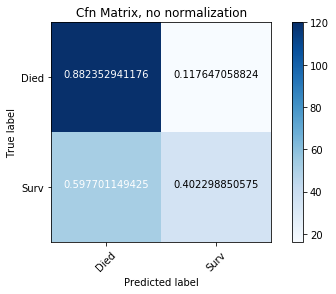

In [284]:
plt.figure()
plot_confusion_matrix(cfn_matrix_minimal, ['Died', 'Surv'], normalize=True, title="Cfn Matrix, no normalization")

In [285]:
print(classification_report(y_test_minimal, y_pred, target_names=['Died', 'Surv']))

             precision    recall  f1-score   support

       Died       0.70      0.88      0.78       136
       Surv       0.69      0.40      0.51        87

avg / total       0.69      0.70      0.67       223



In [286]:
logreg.score(X,y)

0.70370370370370372

In [287]:
precision_score(y_test_minimal, y_pred)

0.68627450980392157

In [288]:
recall_score(y_test_minimal, y_pred)

0.40229885057471265

### Logistic Regression (with added features)

In [301]:
X = df[df.corr().columns]
y = X.pop('Survived')

In [302]:
X.describe()

,Pclass,Age,SibSp,Parch,Fare,FamSize,Deck_A,Deck_B,Deck_C,Deck_D,...,63.0,64.0,65.0,66.0,70.0,70.5,71.0,74.0,80.0,nan
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.00000,...,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,2.308642,23.799293,0.523008,0.381594,32.204208,0.904602,0.016835,0.052750,0.066218,0.03367,...,0.002245,0.002245,0.003367,0.001122,0.002245,0.001122,0.002245,0.001122,0.001122,0.198653
std,0.836071,17.596074,1.102743,0.806057,49.693429,1.613459,0.128725,0.223659,0.248802,0.18048,...,0.047351,0.047351,0.057961,0.033501,0.047351,0.033501,0.047351,0.033501,0.033501,0.399210
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,6.000000,0.000000,0.000000,7.910400,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,24.000000,0.000000,0.000000,14.454200,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.000000,35.000000,1.000000,0.000000,31.000000,1.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3.000000,80.000000,8.000000,6.000000,512.329200,10.000000,1.000000,1.000000,1.000000,1.00000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [329]:
X_train_features, X_test_features, y_train_features, y_test_features = train_test_split(X, y)

logreg = LogisticRegressionCV(n_jobs=-1)

logreg.fit(X_train_features, y_train_features)

y_pred = logreg.predict(X_test_features)

cfn_matrix_features = confusion_matrix(y_test_features, y_pred)
np.set_printoptions(precision=2)

Confusion matrix, without normalization
[[121  16]
 [ 14  72]]


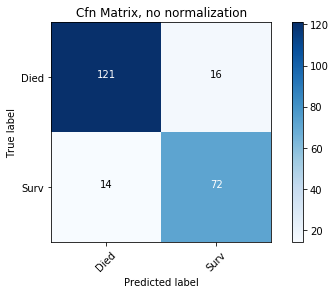

In [330]:
plt.figure()
plot_confusion_matrix(cfn_matrix_features, ['Died', 'Surv'], title="Cfn Matrix, no normalization")

Normalized confusion matrix
[[ 0.88  0.12]
 [ 0.16  0.84]]


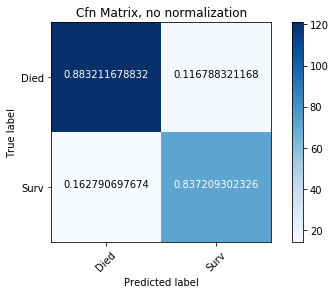

In [331]:
plt.figure()
plot_confusion_matrix(cfn_matrix_features, ['Died', 'Surv'], normalize=True, title="Cfn Matrix, no normalization")

In [332]:
print(classification_report(y_test_features, y_pred, target_names=['Died', 'Surv']))

             precision    recall  f1-score   support

       Died       0.90      0.88      0.89       137
       Surv       0.82      0.84      0.83        86

avg / total       0.87      0.87      0.87       223



In [333]:
logreg.score(X, y)

0.84960718294051629

In [334]:
precision_score(y_test_features, y_pred)

0.81818181818181823

In [335]:
recall_score(y_test_features, y_pred)

0.83720930232558144

In [336]:
logreg.C_

array([ 2.78])

In [337]:
logreg.Cs_

array([  1.00e-04,   7.74e-04,   5.99e-03,   4.64e-02,   3.59e-01,
         2.78e+00,   2.15e+01,   1.67e+02,   1.29e+03,   1.00e+04])

In [338]:
sum(y_test_features)/len(y_test_features)

0.38565022421524664

In [454]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 45 columns):
Survived        891 non-null int64
Pclass          891 non-null int64
Name            891 non-null object
Sex             891 non-null object
Age             891 non-null float64
SibSp           891 non-null int64
Parch           891 non-null int64
Ticket          891 non-null object
Fare            891 non-null float64
Cabin           204 non-null object
Embarked        889 non-null object
Title           891 non-null object
FamSize         891 non-null int64
Deck            200 non-null object
CabinNumber     200 non-null object
Deck_A          891 non-null uint8
Deck_B          891 non-null uint8
Deck_C          891 non-null uint8
Deck_D          891 non-null uint8
Deck_E          891 non-null uint8
Deck_F          891 non-null uint8
Deck_G          891 non-null uint8
Capt            891 non-null uint8
Col             891 non-null uint8
Don             891 non-null uint8
Dr      

In [455]:
df.columns

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'Embarked', 'Title', 'FamSize', 'Deck', 'CabinNumber',
       'Deck_A', 'Deck_B', 'Deck_C', 'Deck_D', 'Deck_E', 'Deck_F', 'Deck_G',
       'Capt', 'Col', 'Don', 'Dr', 'Jonkheer', 'Lady', 'Major', 'Master',
       'Miss', 'Mlle', 'Mme', 'Mr', 'Mrs', 'Ms', 'Rev', 'Sir', 'the Countess',
       'female', 'male', 'Class_1', 'Class_2', 'Class_3', 'has_age'],
      dtype='object')